<a href="https://colab.research.google.com/github/sooonsyk/ESAA-22-2/blob/main/W3_HW_mon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**모델 훈련**

##4.1 선형 회귀
- 입력 특성의 가중치 합과 편향bias/절편 intercept 라는 상수를 더해 예측을 만듦
- 모델 훈련 : 모델이 훈련 세트에 가장 잘 맞도록 모델 파라미터를 설정하는 것
  - 모델이 훈련 데이터에 얼마나 잘 들어맞는지 측정 - 회귀에 가장 널리 사용되는 성능 측정 지표는 평균 제곱근 오차 RMSE, 실제로는 평균 제곱 오차 MSE를 최소화하는 것이 더 간단

###4.1.1 정규 방정식
- 비용 함수를 최소화하는 세타 값을 바로 얻을 수 있는 공식


In [18]:
#선형처럼 보이는 데이터 생성
import numpy as np

X = 2 * np.random.rand(100,1)
y = 4 + 3*X + np.random.randn(100,1)

In [19]:
X_b = np.c_[np.ones((100,1)),X] #모든 샘플에 x0=1 추가
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

- np.linalg.inv() : 역행렬
- np.linalg.dot() : 행렬 곱셈

In [20]:
theta_best

array([[4.19961396],
       [2.84066872]])

- 4와 3을 기대했지만 잡음 때문에 정확하게 재현 못 함

In [21]:
#세타햇 사용해 예측
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.19961396],
       [9.8809514 ]])

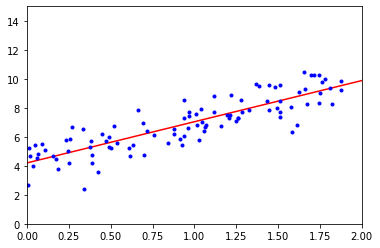

In [22]:
#그래프
import matplotlib.pyplot as plt

plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, 'b.')
plt.axis([0,2,0,15])
plt.show()

####사이킷런 선형회귀

In [23]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
print(lin_reg.intercept_, lin_reg.coef_)
lin_reg.predict(X_new)

[4.19961396] [[2.84066872]]


array([[4.19961396],
       [9.8809514 ]])

- LinearRegression 클래스는 scipy.linalg.lstsq() 함수를 기반으로 함, 직접 호출 가능

In [24]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.19961396],
       [2.84066872]])

- $\hat{\theta} = X^+y$ 계산함
  - $X^+$ 는 $X$의 유사역행렬, np.linalg.pinv()로 구할 수 있음

In [25]:
np.linalg.pinv(X_b).dot(y)

array([[4.19961396],
       [2.84066872]])

- 특이값 분해 SVD 라 부르는 표준 행렬 뷴해 기법을 사용해 계산
  - 훈련 세트 행렬 X를 3개의 행렬 곱셈 $U \Sigma V^T$로 분해함
  - 유사역행렬은 $X^+ = V\Sigma^+ U^T$ 로 계산
  - $\Sigma^+$를 계산하기 위해 알고리즘이 $\Sigma$를 먼저 구하고 어떤 낮은 임곗값보다 작은 모든 수를 0으로 바꿈, 그 다음 0이 아닌 모든 값을 역수로 치환, 마지막으로 만들어진 행렬 전치
  - 정규방정식보다 효율적, $X^TX$의 역행렬 없다면 정규방정식은 작동하지 않지만 유사역행렬은 항상 구할 수 있음
  

###4.1.2 계산복잡도
- (n+1)*(n+1) $X^TX$의 역행렬을 계산하는 계산 복잡도는 일반적으로 $O(n^{2.4})$ 에서 $O(n^3)$ 사이
  - 사이킷런이 사용하는 SVD 는 약 $O(n^2)$
- 학습된 선형 회귀 모델은 예측 매우 빠름, 예측 계산 복잡도는 샘플 수와 특성 수에 선형적

##4.2 경사하강법
- 여러 종류의 문제에서 최적의 해법을 찾을 수 있는 일반적인 최적화 알고리즘
- 비용 함수를 최소화하기 위해 반복해서 파라미터 조정
- θ 를 임의의 값으로 시작해서 한 번에 조금씩 비용함수 감소되는 방향으로 진행 - 무작위 초기화
- 가장 중요한 파라미터 : 스텝의 크기 학습률 learning rate
- 선형 회귀를 위한 MSE 비용함수는 볼록함수이기 때문에 지역 최솟값 없고 전역 최솟값만 있음, 연속함수
  - 경사 하강법이 전역 최솟값에 가깝게 접근할 수 있다는 것 보장


###4.2.1 배치 경사 하강법
- 각 모델 파라미터에 대해 비용 함수의 그레이디언트 계산해야함 - 편도함수

In [26]:
eta = 0.1
n_iterations = 1000
m=100

theta = np.random.randn(2,1) #무작위 초기화

for iteration in range(n_iterations):
  gradients = 2/m * X_b.T.dot(X_b.dot(theta)-y)
  theta = theta - eta*gradients

In [27]:
theta

array([[4.19961396],
       [2.84066872]])

- 적절한 학습률 찾으려면 그리드 탐색 사용 - 수렴하는 데 너무 오래 걸리는 모델을 막기 위해 반복 횟수 제한해야 함
  - 반복 획수 아주 크게 지정하고 그레이디언트 벡터가 아주 작아지면, 허용 오차보다 작아지면 알고리즘 중지
  

###4.2.2 확률적 경사 하강법
- 배치 경사 하강법 문제 : 매 스텝에서 전체 훈련 세트를 사용해 그레이디언트 계산, 느려짐
- 매 스텝에서 한 개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 그레이디언트 계산
  - 빠르고 큰 데이터도 다룰 수 있지만 훨씬 불안정
  - 학습률 점진적으로 감소시켜서 해결
  

In [28]:
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
  return t0/(t+t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
  for i in range(m):
    random_index = np.random.randint(m)
    xi = X_b[random_index:random_index+1]
    yi = y[random_index:random_index+1]
    gradients = 2*xi.T.dot(xi.dot(theta)-yi)
    eta - learning_schedule(epoch*m + i)
    theta = theta - eta*gradients
    

In [29]:
theta

array([[4.2867791 ],
       [3.45139756]])

- 샘플을 무작위로 선택하기 때문에 어떤 샘플은 여러번 선택될수도, 아예 선택 안 될 수도
- 사이킷런에서 SGD 방식으로 선형 회귀를 사용하려면 기본값으로 제곱 오차 비용함수를 최적화하느 SGDRegressor 클래스 사용 

In [30]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X,y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [31]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.15653745]), array([2.85274907]))

###4.2.3 미니배치 경사 하강법
- 미니배치라 부르는 임의의 작은 샘플 세트에 대해 그레이디언트 계산
- 확률적 경사 하강법에 비해 행렬 연산에 최적화된 하드웨어, GPU 사용시 성능 향상


##4.3 다항회귀
- 비선형 데이터를 학습하는 데 선형 모델 사용 가능 - 각 특성의 거듭제곱을 새로운 특성으로 추가하여 선형 모델을 훈련시키는 것


In [32]:
#2차 방정식
m = 100
X = 6*np.random.rand(m,1)-3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

In [33]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0], X_poly[0])

[1.49205612] [1.49205612 2.22623147]


- PolynomialFeatures 사용해 훈련 데이터 변환
  - 훈련 세트에 있는 각 특성을 제곱(2차 다항)하여 새로운 특성으로 추가 

In [34]:
#확장된 훈련 데이터에 LinearRegression 적용
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.04375346]), array([[0.98135287, 0.49587623]]))

- 특성이 여러개일 때 다항 회귀는 이 특성 사이의 관계 찾을 수 있음
  - PolynomialFeatures가 모든 교차항을 추가하기 때문

#4.4 학습 곡선
- 과대적합 : 훈련 데이터에서 성능이 좋지만 교차 검증 점수가 나쁜 경우
- 과소적합 : 훈련 데이터에서 성능, 교차 검증 점수 모두 나쁜 경우
- 학습 곡선 :  훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기의 함수로 나타냄
  - 훈련 세트에서 크기가 다른 서브 세트를 만들어 모델 여러 번 훈련시킴

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def plot_learning_curves(model, X, y):
  X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2)
  train_errors, val_errors = [], []
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
  plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='train')
  plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='test')

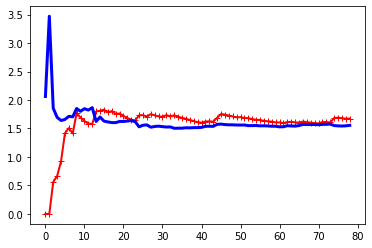

In [36]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
# x 훈련 세트 크기, y RMSE

- 훈련 데이터 : 0에서 시작, 샘플 1-2개 일 때 완벽, 샘플 늘어남에 따라 오차 상승하다가 평평해짐
- 검증 데이터 : 샘플 적을 땐 제대로 일반화할 수 없어서 오차 큼, 샘플 늘어남에 따라 오차 감소
- 과소적합 모델의 전형적인 모습, 두 곡선이 수평한 구간을 만들고 꽤 높은 오차에서 매우 가까이 근접
- 과소적합 돼있다면 훈련 샘플 더 추가해도 효과 없음

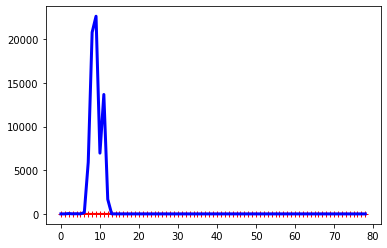

In [37]:
#10차 다항 회귀
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('lin_alg', LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)

- 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮음, 두 곡선 사이에 공간 있음 - 훈련 데이터에서의 모델 성능이 검증 데이터에서보다 훨씬 낫다는 뜻 -> 과대적합
- 과대적합을 개선하는 한 가지는 더 많은 훈련 데이터 추가하는 것

- 편향 분산 트레이드 오프 : 모델의 복잡도가 커지면 분산이 늘어나고 편향이 줄어들고, 복잡도가 줄어들면 편향이 커지고 분산이 작아짐

##4.5 규제가 있는 선형 모델
- 과대적합을 감소시키는 좋은 방법은 모델을 규제하는 것
  - 자유도 줄이면 과대적합 어려움
  - 다항회귀 모델을 규제하는 간단한 방법은 차수 감소
  - 선형회귀 모델에서는 보통 가중치 제한

###4.5.1 릿지 회귀
- 규제가 추가된 선형 회귀, 규제 항목이 비용함수에 추가
- 학습 알고리즘을 데이터에 맞추는 것뿐만 아니라 모델의 가중치가 가능한 한 작게 유지되도록 함
- 규제항은 훈련하는 동안에만 비용 함수에 추가됨, 훈련이 끝나면 모델의 성능을 규제 없는 성능 지표로 평가
- 비용 함수 : $J(\theta) = MSE(\theta) + \alpha\frac{1}{2}\sum_{i=1}^{n}\theta_i^2$
  - $\alpha$ 는 모델을 얼마나 많이 규제할 지 조절, 0이면 선형회귀와 같아짐, 아주 크면 모든 가중치가 0에 가까워지고 데이터의 평균을 지나는 수평선이 됨
  - 편향 $\theta_0$은 규제되지 않음
- 정규 방정식을 사용할 수도 있고 경사 하강법을 사용할 수도 있음

In [38]:
#정규 방정식
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[4.90918753]])

In [40]:
#경사 하강법
sgd_reg = SGDRegressor(penalty='l2')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.89009161])

- penalty 매개변수는 사용할 규제 지정, l2는 릿지회귀

###4.5.2 라쏘회귀
- 선형 회귀의 또 다른 규제된 버전
- 덜 중요한 특성의 가중치를 0으로 제거 - 자동으로 특성 선택을 하고 희소 모델을 만듦


In [41]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([4.85776998])

- SGDRegressor(penalty='l1') 사용 가능

###4.5.3 엘라스틱넷
- 릿지 회귀와 라쏘 회귀 절충 모델
- 혼합 비율 r을 사용해 조절, 0이면 릿지회귀와 같고 1이면 라쏘회귀와 같음
- 릿지가 기본이지만 쓰이는 특성이 몇개뿐이라고 의심되면 라쏘나 엘라스틱넷이 나음

In [43]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)  #l1_ratio 가 혼합 비율
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([4.86018832])

###4.5.4 조기 종료
- 경사 하강법과 같은 반복적인 학습 알고리즘을 규제하는 색다른 방식은 검증 에러가 최솟값에 도달하면 바로 훈련을 중지시키는 것




```
#조기 중료 구현 코드

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

#데이터 준비
poly_scaler = Pipeline([('poly_features', PolynomialFeatures(degree=90, include_bias=False)),
                        ('std_scaler', StandardScaler())
                        ])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None, learning_rate='constant', eta0=0.0005)

minimlum_val_error = float('inf')
best_epoch = None
best_model = None
for epoch in range(1000):
  sgd_reg.fit(X_train_poly_scaled, y_train)
  y_val_predict = sge_reg.predict(X_val_poly_scaled)
  val_error = mean_squared_error(y_val, y_val_predict)
  if val_error < minimum_val_error:
    minimum_val_error = val_error
    best_epoch = epoch
    best_model = clone(sgd_reg)
```



- warm_start = True 로 지정하면 fit() 호출될 때 처음부터 다시 시작하지 않고 이전 모델 파라미터에서 훈련 이어감

##4.6 로지스틱 회귀
- 분류에서도 사용할 수 있는 회귀 알고리즘
- 샘플이 특정 클래스에 속할 확률을 추정하는 데 널리 사용됨, 이진 분류기

###4.6.1 확률 추정
- 입력 특성의 가중치 합을 계산하고 편향을 더함, 바로 결과를 출력하지 않고 결과값의 로지스틱을 출력
- 로지스틱 : 0,1 사의 값을 출력하는 시그모이드 함수 (s자함수)

###4.6.2 훈련과 비용 함수
- 양성 샘플에 대해서는 높은 확률을 추정하고 음성 샘플에 대해서는 낮은 확룰을 추정하는 모델 파라미터 백터 찾기

###4.6.3 결정 경계
- 붓꽃 데이터셋 : 세 개의 품종에 속하는 붓꽃 150 개의 꽃입과 꽃받침의 너비와 길이 데이터

In [47]:
#꽃잎의 너비를 기반으로 Versicolor 종 감지 분류기

#데이터 로드
from sklearn import datasets
iris = datasets.load_iris()
X = iris['data'][:,3:] #꽃잎의 너비
y = (iris['target']==2).astype(np.int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


In [48]:
#로지스틱 회귀 모델 훈련
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

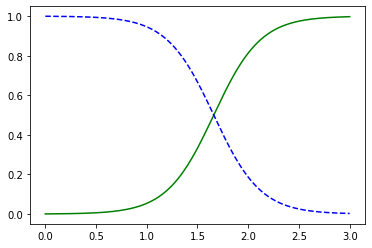

In [49]:
X_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:,1], 'g-', label='Iris virginica')
plt.plot(X_new, y_proba[:,0], 'b--', label = 'Not Iris virginica')
# x 꽃잎너비, y 확률

###4.6.4 소프트맥스 회귀/ 다항 로지스틱 회귀
- 로지스틱 회귀 모델을 여러 개의 이진 분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화
  - 샘플이 주어지면 먼저 소프트맥스 회귀 모델이 각 클래스에 대한 점수를 계산하고, 그 점수에 소프트 맥스 함수를 적용하여 각 클래스의 확률 추정
  - 크로스 엔트로피 비용 함수를 최소화하는 것이 타깃 클래스에 대해 낮은 확률을 예측하는 모델을 억제하므로 부합

In [50]:
#  붓꽃 세 개의 클래스로 분류

X = iris['data'][:,(2,3)]
y = iris['target']

softmax_reg = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', C=10)
softmax_reg.fit(X,y)

LogisticRegression(C=10, multi_class='multinomial')

- 사이킷런의 LogisticRegression 은 클래스가 둘 이상일 때 기본적으로 일대다 전략 사용, multi_class 매개변수를 multinomial로 바꾸면 소프트맥스 사용할 수 있음, solver 매개변수에 lbfgs와 같이 소프트맥스 회귀를 지원하는 알고리즘 지정해야 함

In [51]:
softmax_reg.predict([[5,2]])

array([2])

In [52]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])